In [1]:
import matplotlib.pyplot as plt

import numpy as np
from scipy import linalg

from sklearn.decomposition import PCA

from neurodsp.sim import sim_powerlaw, sim_action_potential

from tqdm.notebook import tqdm

## Low Rank Appoximations


In [2]:
def sim_circulant(sig):
    """Simulates a circulant matrix."""
    n = len(sig)
    X = np.zeros((n, n))
    for i in range(len(sig)):
        X[i] = np.roll(sig, i)
    return X

def compute_epsilon(X):
    """Determine if X is circulant."""
    
    X = np.cov(X, rowvar=False)

    n = len(X)
    
    # Fourier modes (e.g. cosines)
    vecs = np.fft.fft(np.eye(n)) / np.sqrt(n)
    
    # Eigenvalues given cosines as eigenvectors
    Lambda = (vecs.conj().T @ X @ vecs)
    
    # Error measure
    epsilon = (1/n) * np.linalg.norm((Lambda * np.eye(len(Lambda))) - Lambda)**2

    return epsilon

In [3]:
# Temporally shifted action potentials
x = np.linspace(-100, 100, 100)
sigma = 20
gaussian = 10 * np.exp(-0.5 * (x/sigma)**2) / (sigma * np.sqrt(2 * np.pi))
gaussian = np.pad(gaussian, (200, 200))

_X = sim_circulant(gaussian) 

X_g = []
inds = np.arange(500)
for i in range(20):
    np.random.seed(i)
    np.random.shuffle(inds)
    X_g.append(_X[inds])


X_g = np.vstack(X_g)
X_g = X_g + np.random.rand(*X_g.shape)/20

# Powerlaws
X_p = np.array([
    sim_powerlaw(1, 500, exponent=-2)
    for i in range(10000)
])

In [4]:
print(f'eps gaussian    : {compute_epsilon(X_g)}')
print(f'eps powerlaw    : {compute_epsilon(X_p)}')

eps gaussian    : 2.9779528648097553e-08
eps powerlaw    : 0.03777425529684387


In [5]:
# SVD of temporal shifts
k = 50

U_g, S_g, Vt_g = linalg.svd(X_g, full_matrices=False)
V_g = Vt_g.T

X_k_g = U_g[:, :k] @ np.diag(S_g[:k]) @ V_g[:, :k].T
X_1_g = U_g[:, :1] @ np.diag(S_g[:1]) @ V_g[:, :1].T

# SVD of powerlaws
U_p, S_p, Vt_p = linalg.svd(X_p, full_matrices=False)
V_p = Vt_p.T

X_k_p = U_p[:, :k] @ np.diag(S_p[:k]) @ V_p[:, :k].T
X_1_p = U_p[:, :1] @ np.diag(S_p[:1]) @ V_p[:, :1].T

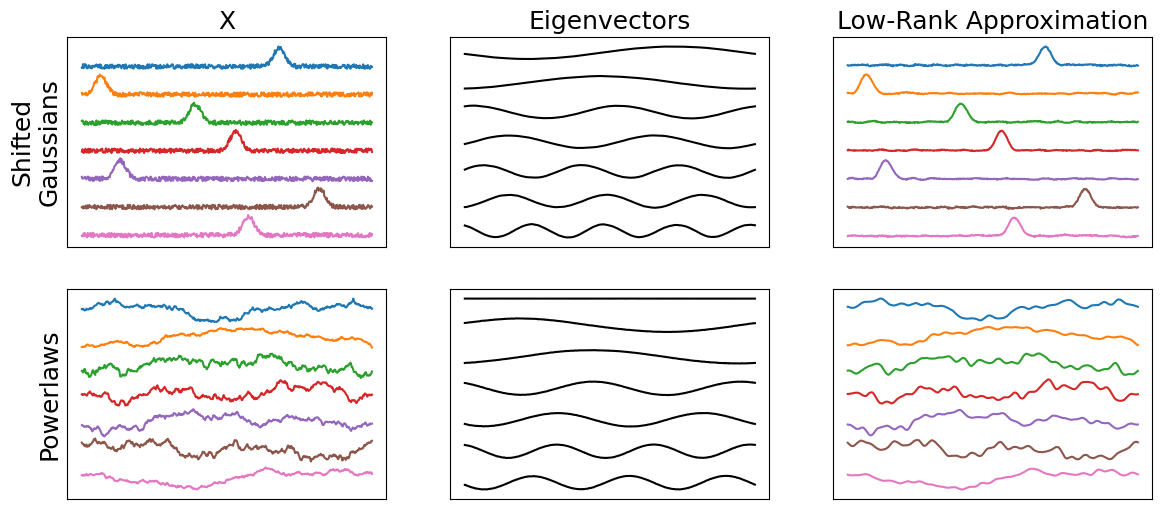

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))

# (0, 0)
ii = 0
inds_g = [0, 2, 3, 5, 6, 8, 19]
for i in X_g[inds_g]:
    axes[0][0].plot(i-ii)
    ii += .3

# (1, 0)
ii = 0
for i in X_p[:7]:
    axes[1][0].plot(i-ii)
    ii += 5

# (0, 1)
ii = 0
for i in Vt_p[:7]:
    axes[0][1].plot(i-ii, color='k')
    ii += .3

# (1, 1)
ii = 0
for i in Vt_g[:7]:
    axes[1][1].plot(i-ii, color='k')
    ii += .3

# (0, 2)
ii = 0
for i in X_k_g[inds_g]:
    axes[0][2].plot(i-ii)
    ii += .3

# (1, 2)
ii = 0
for i in X_k_p[:7]:
    axes[1][2].plot(i-ii)
    ii += 5

axes[0][0].set_title(r"X", size=18)
axes[0][1].set_title(r"Eigenvectors", size=18)
axes[0][2].set_title(r"Low-Rank Approximation", size=18)

axes[0][0].set_ylabel("Shifted\nGaussians", size=18)
axes[1][0].set_ylabel("Powerlaws", size=18)

for i in axes:
    for j in i:
        #j.axis("off")
        j.set_xticks([])
        j.set_yticks([])

# plt.savefig("/Users/ryanhammonds/Desktop/fig_02.png", dpi=300)

## Converge to Circulant Matrices

In [106]:
sizes = np.array([1e1, 1e2, 1e3, 1e4]).astype(int)
eps = []

ds = [
    lambda i: np.random.randn(i, 1000),
    lambda i: np.random.uniform(0, 1., size=(i, 1000)),
    lambda i: np.random.exponential(1.0, size=(i, 1000)),
]

# Fourier modes (e.g. cosines)
vecs = np.fft.fft(np.eye(1000)) / np.sqrt(1000)

for d in ds:

    
    _eps = np.zeros((len(sizes), 20))
    
    for ii, i in tqdm(enumerate(sizes), total=len(sizes)):    
        
        for j in range(20):
    
            X = d(i)
            X = np.cov(X.T)
            
            # Eigenvalues given cosines as eigenvectors
            Lambda = (vecs.conj().T @ X @ vecs)
            
            # Error measure
            epsilon = (1/1000) * np.linalg.norm((Lambda * np.eye(len(Lambda))) - Lambda)**2
        
            # Epsilon -> zero == circulant matrix == oscillatory eigenvectors
            _eps[ii][j] = epsilon
        
    eps.append(_eps)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [108]:
# plt.loglog(sizes/1000, eps[0].mean(axis=1), label="Normal")
# plt.loglog(sizes/1000, eps[1].mean(axis=1), label="Uniform")
# plt.loglog(sizes/1000, eps[2].mean(axis=1), label="Exponential")

In [110]:
from scipy import stats

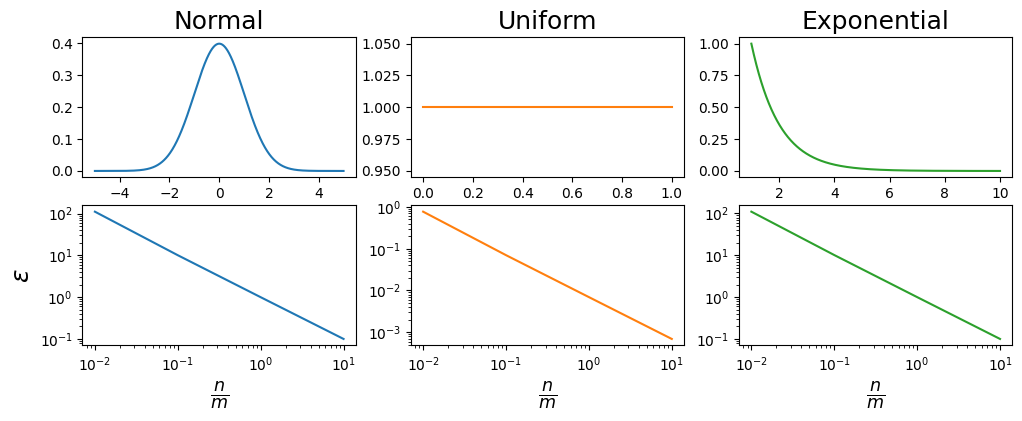

In [136]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=2, ncols=3)

axes[0][0].plot(np.linspace(-5, 5, 1000), stats.norm.pdf(np.linspace(-5, 5, 1000), 0, 1))
axes[0][1].plot(np.linspace(0, 1, 1000), stats.uniform.pdf(np.linspace(0, 1, 1000), 0, 1), color='C1')
axes[0][2].plot(np.linspace(1, 10, 1000), stats.expon.pdf(np.linspace(1, 10, 1000), 1), color='C2')

axes[0][0].set_title("Normal", size=18)
axes[0][1].set_title('Uniform', size=18)
axes[0][2].set_title("Exponential", size=18)

axes[1][0].set_ylabel(r"$\epsilon$", size=18)
axes[1][0].set_xlabel(r"$\frac{n}{m}$", size=18)
axes[1][1].set_xlabel(r"$\frac{n}{m}$", size=18)
axes[1][2].set_xlabel(r"$\frac{n}{m}$", size=18)

axes[1][0].loglog(sizes/1000, eps[0].mean(axis=1))
axes[1][1].loglog(sizes/1000, eps[1].mean(axis=1), color='C1')
axes[1][2].loglog(sizes/1000, eps[2].mean(axis=1), color='C2')

plt.savefig('circulant_convergence.png', dpi=300)